In [203]:
%load_ext autoreload
%autoreload 2
%aimport -pylab
%pylab inline
from pyzdde.zfileutils import  writeBeamFile, readBeamFile
from astropy.visualization import simple_norm
from astropy.modeling import models, fitting
import scipy.ndimage as nd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


C:\Users\bruno\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [171]:
import pyzdde.zdde as pyz
from tqdm.notebook import tqdm
from astropy.modeling import models, fitting
import os
import pathlib
import scipy.ndimage as nd
from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelmin,find_peaks
from scipy.stats import binned_statistic
from astropy.modeling import models, fitting

In [186]:
def ana_PSF(f,do_plot = False):
    data=loadtxt(f,skiprows=19)
    
    # real FWHM
    
    spld = UnivariateSpline(arange(100), data.sum(axis=0))
    spld.set_smoothing_factor(1e5)
    
    
    prd = spld(arange(1000)/10)
    rd = find_peaks(prd.max()-abs(prd-prd.max()/2),height = 3*prd.max()/4,distance = 100)
    
    
        
    splc = UnivariateSpline(arange(100), data.sum(axis=1))
    splc.set_smoothing_factor(1e5)
    
    prc = splc(arange(1000)/10)
    rc = find_peaks(prc.max()-abs(prc-prc.max()/2),height = 3*prc.max()/4,distance = 100)
    
    #print( 3*prd.max()/8,rd, 3*prc.max()/8,rc)   
    wd = rd[0][1]-rd[0][0]
    wc = rc[0][1]-rc[0][0]
    
    # gaussian fit on a pixel sampled measurement
    ad=binned_statistic(arange(100)*2,data.sum(axis=0),bins=arange(15)*15)
    ac=binned_statistic(arange(100)*2,data.sum(axis=1),bins=arange(15)*15)
    p_init = models.Gaussian1D(amplitude = prc.max(),
                          mean = 100,
                          stddev = 2)
    fit_p = fitting.LevMarLSQFitter()
    fd = fit_p(p_init,ad[1][0:-1]+7.5,ad[0])
    fc = fit_p(p_init,ac[1][0:-1]+7.5,ac[0])
    
    if do_plot:
        figure()
        imshow(data)
        figure()
        plot(arange(100)*2,data.sum(axis=0),".")
        plot(arange(100)*2,spld(arange(100)))
        plot(ad[1][0:-1]+7.5,ad[0],".")
        plot(arange(100)*2,fd(arange(100)*2))
        #print(rd[0]/10)
        axvline(rd[0][0]/10.*2,c="r",ls="--")
        axvline(rd[0][1]/10.*2,c="r",ls="--")
        title(f"{wd*2/10:0.1f} $\mu$ m ,{wd*2/150:0.1f} pixels")
       
        figure()
        plot(arange(100)*2,data.sum(axis=1),".")
        plot(arange(100)*2,splc(arange(100)))
        plot(ac[1][0:-1]+7.5,ac[0],".")
        plot(arange(100)*2,fc(arange(100)*2))
        axvline(rc[0][0]/10.*2,c="r",ls="--")
        axvline(rc[0][1]/10.*2,c="r",ls="--")
        title(f"{wc*2/10:0.1f} $\mu$ m ,{wc*2/150:0.1f} pixels")
        
    return wd/150*2,wc/150*2, fd.fwhm/15, fc.fwhm/15

In [184]:
def calculate_spectro_psf(nconfig,nwl):
    ln = pyz.createLink()
    
    cbname = "Z:\\Documents\\travail\\ObsGe\\NIRPS\\config_"
    fname = ln.zGetFile()
    p = pathlib.Path(".")
    
    p = p / fname.replace(".zmx","").replace(".ZMX",".")
    try:
        os.mkdir(p)
    except:
        "Overwriting or issue with the path"
    
    if isinstance(nconfig,list):
        cc = nconfig
    else:
        cc = range(nconfig)
    
    if isinstance(nwl,list):
        ll = nwl
    else:
        ll = range(nwl)
        
    wl0 = []
    wd = []
    wc = []
    wgd = []
    wgc = []
    x = []
    for c in tqdm(cc):
        ln.zSetConfig(c+1)
        ln.zPushLens()
        wwd=[]
        wwgc=[]
        wwgd=[]
        wwc=[]
        
        wwl=[]
        xx=[]
        for i in ll:
            wwl.append(ln.zGetWave(i+1).wavelength*1000.)
            ofile = p / ("PSF_%03d_%03d.txt"%(i,c))
            ln.zModifySettings(cbname+f"{i+1}.CFG","IMA_IMAGESIZE", 0.2)
            res = ln.zGetTextFile(str(ofile.absolute()),"Ima",cbname+f"{i+1}.CFG",1)
            #print("get file, ", res)
            r=ana_PSF(ofile,do_plot=False)
            wwd.append(r[0])
            wwc.append(r[1])
            wwgd.append(r[2])
            wwgc.append(r[3])
            (xb,yb,zb,intensityb) = ln.zSpiralSpot(0,1,i+1,3,10)
            xx.append(mean(xb))
        wl0.append(wwl)
        wd.append(wwd)
        wc.append(wwc)
        wgd.append(wwgd)
        wgc.append(wwgc)
        x.append(xx)
        
    wl0 = array(wl0)
    wd = array(wd)
    wc = array(wc)
    wgd = array(wgd)
    wgc = array(wgc)
    x = array(x)
    
    pyz.closeLink()
    
    figure()
    subplot(122)
    plot(x.flatten(),wd.flatten(),".")
    plot(x.flatten(),wgd.flatten(),".")
    title("Dispertion")
    ylim(2,5)
    grid()
    subplot(121)
    plot(x.flatten(),wc.flatten(),".")
    plot(x.flatten(),wgc.flatten(),".")
    title("Cross Dispertion")
    ylim(2,5)
    grid()
    return wl0,wd,wc,wgd,wgc,x

# Focus initial

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.12      , 3.13333333, 2.61333333],
        [3.69333333, 3.06666667, 2.62666667],
        [3.50666667, 3.08      , 2.76      ]]),
 array([[3.09333333, 3.        , 3.16      ],
        [3.12      , 3.        , 3.09333333],
        [3.41333333, 3.42666667, 3.61333333]]),
 array([[3.65489127, 2.64965218, 2.33494064],
        [3.09068566, 2.57181943, 2.32774068],
        [2.91313553, 2.55228244, 2.37188817]]),
 array([[2.88083532, 2.60855418, 2.6909068 ],
        [2.63617184, 2.60756559, 2.68625968],
        [2.96706251, 2.90252041, 2.98648617]]),
 array([[ 30.92569162,  -3.22885325, -29.98637848],
        [ 18.85721084,  -3.26469065, -21.99886118],
        [ 13.29573779,  -3.27596434, -17.86016306]]))

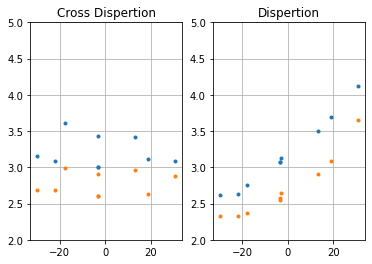

In [199]:
calculate_spectro_psf([0,34,68],[0,2,4])

# tilt 1° CCD

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.10666667, 3.06666667, 4.68      ],
        [3.53333333, 3.09333333, 3.12      ],
        [3.33333333, 3.04      , 2.78666667]]),
 array([[3.26666667, 3.06666667, 3.88      ],
        [3.02666667, 3.06666667, 3.26666667],
        [3.46666667, 3.52      , 3.44      ]]),
 array([[3.88679542, 2.68059754, 4.47587516],
        [3.25711426, 2.5703552 , 3.12379599],
        [3.04079476, 2.56098781, 2.74637746]]),
 array([[3.2245205 , 2.58275026, 3.79719481],
        [2.89192856, 2.58513028, 3.22894793],
        [2.95095143, 2.89086111, 3.24550078]]),
 array([[ 30.84225223,  -3.2291372 , -30.0546338 ],
        [ 18.82369733,  -3.26497765, -22.03565005],
        [ 13.27812193,  -3.27625202, -17.883992  ]]))

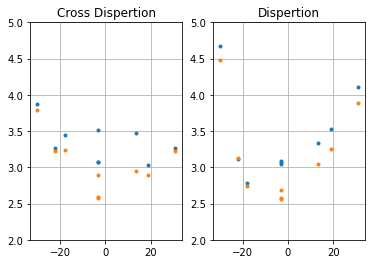

In [204]:
calculate_spectro_psf([0,34,68],[0,2,4])

# tilt -1 ° CCD

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.41333333, 3.18666667, 3.66666667],
        [3.57333333, 2.98666667, 3.41333333],
        [3.37333333, 3.        , 3.        ]]),
 array([[4.93333333, 2.94666667, 3.64      ],
        [3.18666667, 2.94666667, 3.22666667],
        [3.41333333, 3.38666667, 3.41333333]]),
 array([[4.33393114, 2.64143038, 3.51156597],
        [3.32731446, 2.59334016, 3.32666044],
        [3.03912264, 2.56446337, 3.02182758]]),
 array([[4.654077  , 2.66144723, 3.59088444],
        [3.13166314, 2.65553283, 3.19719548],
        [3.24189071, 2.92653317, 3.13176752]]),
 array([[ 31.01906692,  -3.22955452, -29.92754832],
        [ 18.89661706,  -3.26539991, -21.96889017],
        [ 13.31746774,  -3.27667638, -17.84183632]]))

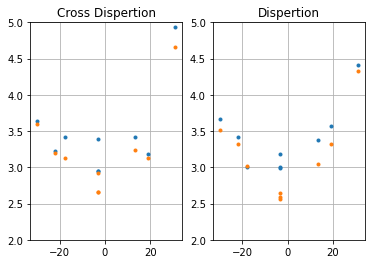

In [205]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus avec fold mirror 100 um

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.10666667, 3.02666667, 2.78666667],
        [3.57333333, 2.94666667, 2.64      ],
        [3.37333333, 2.92      , 2.68      ]]),
 array([[3.36      , 2.98666667, 3.06666667],
        [3.        , 3.        , 3.04      ],
        [3.44      , 3.34666667, 3.41333333]]),
 array([[3.81126968, 2.85899249, 2.77369824],
        [3.15332126, 2.64048791, 2.46721773],
        [2.99927948, 2.65763064, 2.45538878]]),
 array([[3.33161547, 2.60200352, 2.84083937],
        [2.82663246, 2.60700404, 2.78856648],
        [3.29981489, 2.95105244, 3.15304333]]),
 array([[ 30.92358991,  -3.22954156, -29.98596527],
        [ 18.85619527,  -3.26532284, -21.99917421],
        [ 13.29549471,  -3.27653768, -17.86103733]]))

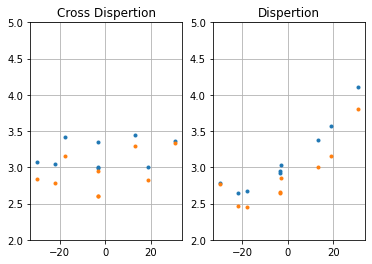

In [206]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus avec fold mirror 300 um

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.73333333, 4.52      , 5.24      ],
        [3.90666667, 3.78666667, 4.13333333],
        [3.85333333, 3.90666667, 3.94666667]]),
 array([[5.6       , 3.57333333, 4.28      ],
        [4.53333333, 3.56      , 4.13333333],
        [5.52      , 4.21333333, 4.85333333]]),
 array([[4.6299429 , 4.26900709, 4.92402776],
        [3.85231693, 3.6888385 , 3.98823352],
        [3.79723682, 3.78672553, 3.82311955]]),
 array([[5.21504796, 3.5110769 , 4.12016685],
        [4.29958188, 3.50421654, 3.98430466],
        [5.16758158, 4.1203241 , 4.64790068]]),
 array([[ 30.9193706 ,  -3.23092419, -29.98513711],
        [ 18.85415691,  -3.26659278, -21.9998045 ],
        [ 13.29500872,  -3.27768943, -17.86279573]]))

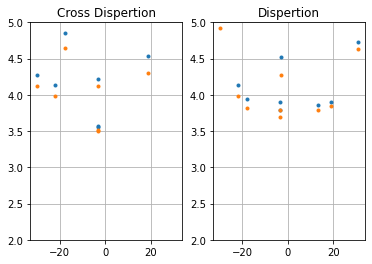

In [208]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus ini avec lentille cylindrinque erreur de 5°

C:\Users\bruno\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.13333333, 3.18666667, 3.16      ],
        [3.65333333, 3.06666667, 2.61333333],
        [3.41333333, 3.08      , 2.69333333]]),
 array([[3.08      , 2.98666667, 3.08      ],
        [3.14666667, 2.97333333, 3.04      ],
        [3.38666667, 3.44      , 3.61333333]]),
 array([[3.96063161, 2.63914152, 3.15197491],
        [3.09980439, 2.57116049, 2.40050167],
        [2.94715685, 2.55411525, 2.38441664]]),
 array([[2.93983788, 2.62637728, 2.85586983],
        [2.63297329, 2.60938505, 2.73709452],
        [3.01183897, 2.89972689, 2.98274335]]),
 array([[ 30.69719232,  -3.37974008, -30.18444821],
        [ 18.78242075,  -3.33417009, -22.079501  ],
        [ 13.36313614,  -3.227593  , -17.80552175]]))

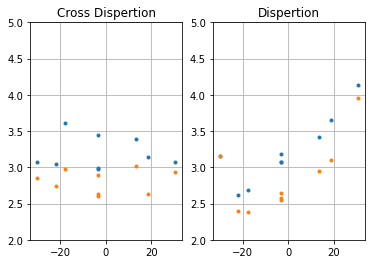

In [209]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Defocus fold mirror 300 mu compensé par 600 mu détecteur

C:\Users\bruno\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.09333333, 3.12      , 2.64      ],
        [3.65333333, 3.        , 2.64      ],
        [3.36      , 3.01333333, 2.66666667]]),
 array([[3.13333333, 3.        , 3.18666667],
        [3.09333333, 2.96      , 3.18666667],
        [3.4       , 3.46666667, 3.44      ]]),
 array([[3.78132068, 2.64264342, 2.31354116],
        [3.08164154, 2.57508797, 2.31297463],
        [2.96484863, 2.55253542, 2.40926095]]),
 array([[3.03248272, 2.62217772, 2.6797236 ],
        [2.64067981, 2.6179486 , 2.65533574],
        [3.20288678, 2.89927936, 3.08099889]]),
 array([[ 30.82113154,  -3.23314913, -29.91230661],
        [ 18.7877164 ,  -3.26880511, -21.94765106],
        [ 13.2441645 ,  -3.27990999, -17.82223049]]))

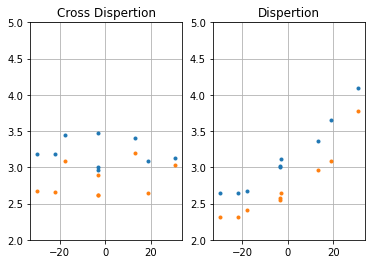

In [210]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus ini avec champ à l'entrée 3mm

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.30666667, 3.10666667, 2.70666667],
        [3.6       , 2.96      , 2.62666667],
        [3.46666667, 3.01333333, 2.74666667]]),
 array([[3.02666667, 2.94666667, 3.04      ],
        [3.05333333, 2.88      , 3.09333333],
        [3.93333333, 3.38666667, 3.73333333]]),
 array([[3.62210005, 2.70565753, 2.32143671],
        [3.19779902, 2.67197406, 2.36986054],
        [2.949362  , 2.57817111, 2.39024911]]),
 array([[2.82937722, 2.5948381 , 2.79602458],
        [3.02055228, 2.71666631, 3.00784711],
        [3.89084324, 3.32087984, 3.68034457]]),
 array([[ 31.61258577,  -2.84559969, -29.79121342],
        [ 19.35015169,  -2.89825304, -21.71526388],
        [ 13.6768176 ,  -2.91945129, -17.50785998]]))

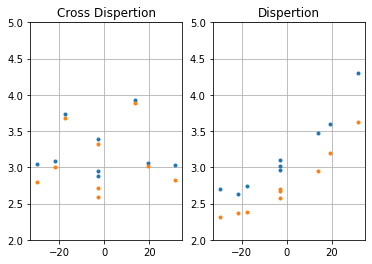

In [201]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus -240 um

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.12      , 3.04      , 2.93333333],
        [3.54666667, 2.93333333, 2.68      ],
        [3.34666667, 2.92      , 2.69333333]]),
 array([[3.38666667, 2.93333333, 3.06666667],
        [3.02666667, 2.94666667, 3.05333333],
        [3.41333333, 3.34666667, 3.42666667]]),
 array([[3.81949968, 2.93082435, 2.94194245],
        [3.20768212, 2.71033543, 2.60378716],
        [3.04145019, 2.7430489 , 2.55644846]]),
 array([[3.37992711, 2.6385469 , 2.91644778],
        [2.90218689, 2.63936534, 2.87203636],
        [3.26131976, 2.94501615, 3.14053299]]),
 array([[ 30.96499068,  -3.22796097, -30.01550931],
        [ 18.8837907 ,  -3.26380342, -22.0197214 ],
        [ 13.31607883,  -3.27507389, -17.8763879 ]]))

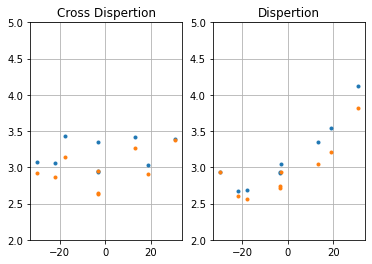

In [193]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus + 240 um

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.09333333, 3.02666667, 2.57333333],
        [3.53333333, 2.96      , 2.70666667],
        [3.34666667, 2.89333333, 2.74666667]]),
 array([[3.09333333, 3.06666667, 3.06666667],
        [3.        , 3.04      , 3.04      ],
        [3.44      , 3.30666667, 3.42666667]]),
 array([[3.65414992, 2.74649123, 2.42267028],
        [3.1704496 , 2.84245532, 2.71352   ],
        [3.05485539, 2.76349891, 2.75720995]]),
 array([[2.79809523, 3.00330043, 2.84470577],
        [2.74699197, 2.99092905, 2.86864902],
        [2.95143489, 3.11456816, 3.06282383]]),
 array([[ 30.88639256,  -3.22974552, -29.95724764],
        [ 18.83063098,  -3.26557787, -21.97800096],
        [ 13.27539675,  -3.27685478, -17.84393823]]))

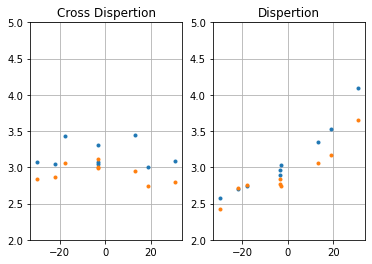

In [194]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus a + 360

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.08      , 3.05333333, 2.73333333],
        [3.52      , 3.21333333, 3.26666667],
        [3.37333333, 3.06666667, 3.30666667]]),
 array([[3.09333333, 3.44      , 3.17333333],
        [3.05333333, 3.44      , 3.18666667],
        [3.34666667, 3.42666667, 3.42666667]]),
 array([[3.71571636, 2.93877518, 2.75077523],
        [3.29940982, 3.1737668 , 3.22131855],
        [3.23540532, 3.06231921, 3.25803019]]),
 array([[2.89191878, 3.40414734, 3.07683747],
        [2.9598854 , 3.40148474, 3.13618799],
        [3.03481475, 3.36815426, 3.19995454]]),
 array([[ 30.86674303,  -3.23019165, -29.94268223],
        [ 18.81734105,  -3.26602148, -21.96757085],
        [ 13.26522624,  -3.27730001, -17.83582581]]))

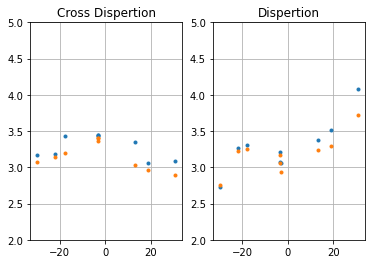

In [195]:
calculate_spectro_psf([0,34,68],[0,2,4])

# Focus a + 480 um

(array([[1808.53 , 1797.29 , 1786.33 ],
        [1271.47 , 1265.92 , 1260.46 ],
        [ 980.353,  977.052,  973.795]]),
 array([[4.09333333, 3.29333333, 3.36      ],
        [3.62666667, 3.73333333, 4.08      ],
        [3.58666667, 3.61333333, 4.12      ]]),
 array([[3.17333333, 4.02666667, 3.49333333],
        [3.33333333, 4.10666667, 3.6       ],
        [3.38666667, 3.76      , 3.52      ]]),
 array([[3.82690897, 3.2625044 , 3.29369034],
        [3.53424474, 3.64888132, 3.85835586],
        [3.52953203, 3.53300696, 3.89503723]]),
 array([[3.08655931, 3.91757579, 3.43920401],
        [3.31537614, 3.93030196, 3.54127019],
        [3.20478173, 3.72387199, 3.44697513]]),
 array([[ 30.8470935 ,  -3.23063779, -29.92811681],
        [ 18.80405112,  -3.26646509, -21.95714074],
        [ 13.25505572,  -3.27774523, -17.82771339]]))

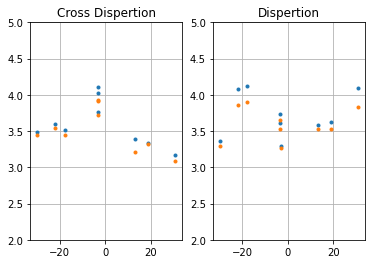

In [196]:
calculate_spectro_psf([0,34,68],[0,2,4])

(4.093333333333334, 3.1066666666666665, 3.6555506232287356, 2.8816861392421624)

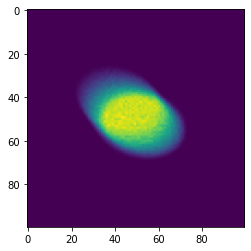

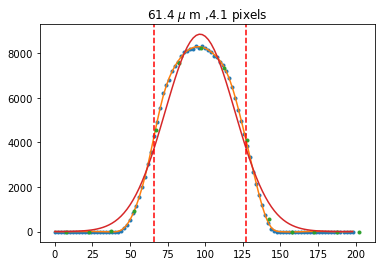

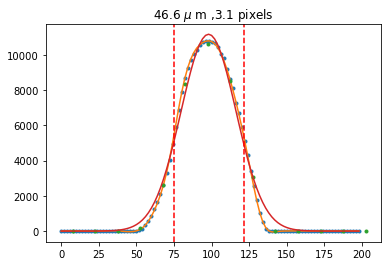

In [198]:
ana_PSF(f,do_plot = True)